In [2]:
!pip install plotly

    100% |████████████████████████████████| 38.6MB 29kB/s eta 0:00:01   21% |██████▉                         | 8.3MB 594kB/s eta 0:00:51
  Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))': /simple/retrying/
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /Users/yonsei/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
You are using pip version 9.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import math
import numpy as np 
import pandas as pd
from pandas import ExcelWriter, ExcelFile 
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import plotly.plotly as py 
import plotly.tools as tls 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [ ]:
#file_location='C:/Users/seul/Desktop/새 폴더/대학원/학회'

In [4]:
hotel_score = pd.read_csv('11_xy1.csv', encoding='euc-kr')#cp949

In [5]:
hotel_score.head()

,Unnamed: 0,가격대비최고이다,가격저렴하다,저렴하다,좋다,추천,깨끗하다,엘레베이터없다,조용하다,강력추천,...,뜨거운물잘나오다,말투무뚝뚝하다,인상별로이다,이동용이하다,생수없다,시설있다,편의시설있다,물별로이다,호텔시설좋지않다,Unnamed: 1578
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,5,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
hotel_score = hotel_score.drop('Unnamed: 0',1)

In [7]:
hotel_score.rename(columns={'Unnamed: 1578':'rating'},inplace=True)

In [8]:
hotel_score.head()

,가격대비최고이다,가격저렴하다,저렴하다,좋다,추천,깨끗하다,엘레베이터없다,조용하다,강력추천,친절하다,...,뜨거운물잘나오다,말투무뚝뚝하다,인상별로이다,이동용이하다,생수없다,시설있다,편의시설있다,물별로이다,호텔시설좋지않다,rating
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


#### undersampling을 통해 Sample 추출 

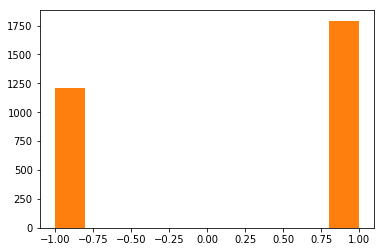

In [10]:
plt.hist(hotel_score.rating)
plt.show()

In [11]:
X = hotel_score.drop(['rating'], axis=1).values
y = hotel_score[['rating']].values

In [12]:
def classify_label(preds):
    labels = []
    for pred in preds:
        if pred > 0:
            labels.append(1)
        else:
            labels.append(-1)
    return labels

In [13]:
def lasso(X_train, y_train, X_test, y_test, alpha):
    clf = Lasso(alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_labeled = classify_label(y_pred)
    return accuracy_score(y_test, y_pred_labeled)

In [14]:
def ridge(X_train, y_train, X_test, y_test, alpha):
    clf = Ridge(alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_labeled = classify_label(y_pred)
    return accuracy_score(y_test, y_pred_labeled)

In [15]:
def elastic(X_train, y_train, X_test, y_test, alpha):
    clf = ElasticNet(alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_labeled = classify_label(y_pred)
    return accuracy_score(y_test, y_pred_labeled)

In [16]:
def adaptive_lasso(X_train, y_train, X_test, y_test, alpha):
    gprime = lambda w: 1. / (2. * np.sqrt(np.abs(w)) + np.finfo(float).eps)
    n_samples, n_features = X_train.shape
    weights = np.ones(n_features)
    n_lasso_iterations = 5
    for k in range(n_lasso_iterations):
        X_w = X_train / weights[np.newaxis, :]
        clf = Lasso(alpha=alpha, fit_intercept=False)
        clf.fit(X_w, y_train)
        coef_ = clf.coef_ / weights
        weights = gprime(coef_)
        
    y_pred = clf.predict(X_test)
    y_pred_labeled = classify_label(y_pred)
    return accuracy_score(y_test, y_pred_labeled)

In [17]:
def main():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    alpha = 10
    lasso_acc = lasso(X_train, y_train, X_test, y_test, alpha)
    ridge_acc = ridge(X_train, y_train, X_test, y_test, alpha)
    elastic_acc = elastic(X_train, y_train, X_test, y_test, alpha)
    adaptive_acc = adaptive_lasso(X_train, y_train, X_test, y_test, alpha)
    print("Lasso's Accuracy: {:.4f} Ridge's Accuracy : {:.4f} Elastic's Accuracy : {:.4f} Adaptive's Accuracy : {:.4f}".format(lasso_acc, ridge_acc, elastic_acc, adaptive_acc))
    print("Finish!")

In [18]:
if __name__ == '__main__':
    main()

Lasso's Accuracy: 0.6467 Ridge's Accuracy : 0.9280 Elastic's Accuracy : 0.6467 Adaptive's Accuracy : 0.3533
Finish!


#### Tuning hyperparameter  -  Cross valdation

In [19]:
# K-fold Cross Validation
def cv(X, y, k_fold):
    kf = KFold(n_splits=k_fold)

    X_train_folds, X_test_folds, y_train_folds, y_test_folds = dict(), dict(), dict(), dict()
    for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
        X_train_folds[fold_index] = X[train_index]
        y_train_folds[fold_index] = y[train_index]
        X_test_folds[fold_index] = X[test_index]
        y_test_folds[fold_index] = y[test_index]
    return X_train_folds, y_train_folds, X_test_folds, y_test_folds

In [20]:
k_fold = 5
X_train_folds, y_train_folds, X_test_folds, y_test_folds = cv(X, y, k_fold)

In [21]:
alphas = np.logspace(-3, -2, 1) # alphas = np.logspace(-3,2)
alphas

array([ 0.001])

In [25]:
from time import time

In [28]:
t = time()
lasso_results, ridge_results, elastic_results, adaptive_results = dict(), dict(), dict(), dict()
for alpha in alphas:
    lasso_cv, ridge_cv, elastic_cv, adaptive_cv = [], [], [], []
    for fold_index in range(k_fold):
        print("Fold : {}, Lambda : {}".format(fold_index+1, alpha))
        lasso_acc, ridge_acc, elastic_acc, adaptive_acc = 0, 0, 0, 0
        lasso_acc = lasso(X_train_folds[fold_index], y_train_folds[fold_index], X_test_folds[fold_index],
                          y_test_folds[fold_index], alpha)
        ridge_acc = ridge(X_train_folds[fold_index], y_train_folds[fold_index], X_test_folds[fold_index],
                          y_test_folds[fold_index], alpha)
        elastic_acc = elastic(X_train_folds[fold_index], y_train_folds[fold_index], X_test_folds[fold_index],
                              y_test_folds[fold_index], alpha)
        adaptive_acc = adaptive_lasso(X_train_folds[fold_index], y_train_folds[fold_index],
                                      X_test_folds[fold_index], y_test_folds[fold_index], alpha)
        lasso_cv.append(lasso_acc)
        ridge_cv.append(ridge_acc)
        elastic_cv.append(elastic_acc)
        adaptive_cv.append(adaptive_acc)
        print("Lasso's Accuracy: {:.4f} Ridge's Accuracy : {:.4f} Elastic's Accuracy : {:.4f} Adaptive's Accuracy : {:.4f}".format(lasso_acc, ridge_acc, elastic_acc, adaptive_acc))
    lasso_cv_acc = np.mean(lasso_cv, axis=0)
    ridge_cv_acc = np.mean(ridge_cv, axis=0)
    elastic_cv_acc = np.mean(elastic_cv, axis=0)
    adaptive_cv_acc = np.mean(adaptive_cv, axis=0)
    lasso_results[alpha] = lasso_cv_acc
    ridge_results[alpha] = ridge_cv_acc
    elastic_results[alpha] = elastic_cv_acc
    adaptive_results[alpha] = adaptive_cv_acc
    print("[Average of {}-fold] Lasso : {:.4f} Ridge : {:.4f} Elastic : {:.4f} Adaptive : {:.4f}".format(k_fold, lasso_cv_acc, ridge_cv_acc, elastic_cv_acc, adaptive_cv_acc))
lasso_lambda = max(lasso_results, key=lasso_results.get)
ridge_lambda = max(ridge_results, key=ridge_results.get)
elastic_lambda = max(elastic_results, key=elastic_results.get)
adaptive_lambda = max(adaptive_results, key=adaptive_results.get)
print("Lasso's optimal lambda value : {}".format(lasso_lambda))
print("Ridge's optimal lambda value : {}".format(ridge_lambda))
print("ElasticNet's optimal lambda value : {}".format(elastic_lambda))
print("Adaptive Lasso's optimal lambda value : {}".format(adaptive_lambda))
print("Finish!")

Fold : 1, Lambda : 0.001
Lasso's Accuracy: 0.9783 Ridge's Accuracy : 0.9067 Elastic's Accuracy : 0.9733 Adaptive's Accuracy : 0.9417
Fold : 2, Lambda : 0.001
Lasso's Accuracy: 0.9783 Ridge's Accuracy : 0.9300 Elastic's Accuracy : 0.9717 Adaptive's Accuracy : 0.9450
Fold : 3, Lambda : 0.001
Lasso's Accuracy: 0.9817 Ridge's Accuracy : 0.9350 Elastic's Accuracy : 0.9817 Adaptive's Accuracy : 0.9550
Fold : 4, Lambda : 0.001
Lasso's Accuracy: 0.8000 Ridge's Accuracy : 0.8367 Elastic's Accuracy : 0.8067 Adaptive's Accuracy : 0.9017
Fold : 5, Lambda : 0.001
Lasso's Accuracy: 0.7930 Ridge's Accuracy : 0.8264 Elastic's Accuracy : 0.7947 Adaptive's Accuracy : 0.9182
[Average of 5-fold] Lasso : 0.9063 Ridge : 0.8869 Elastic : 0.9056 Adaptive : 0.9323
Lasso's optimal lambda value : 0.001
Ridge's optimal lambda value : 0.001
ElasticNet's optimal lambda value : 0.001
Adaptive Lasso's optimal lambda value : 0.001
Finish!


In [29]:
def extract_key_and_value(results):
    return [*results], list(results.values()), 

In [30]:
x_lasso, y_lasso = extract_key_and_value(lasso_results)
x_ridge, y_ridge = extract_key_and_value(ridge_results)
x_elastic, y_elastic = extract_key_and_value(elastic_results)
x_adaptive, y_adaptive = extract_key_and_value(adaptive_results)

In [31]:
plt.rcParams["figure.figsize"] = [25,16]

box = dict(facecolor='pink', pad=5, alpha=0.3)

plt.subplot(2,2,1)
plt.plot(x_lasso, y_lasso, '-ko')
plt.xlabel(r'$\lambda$') #lambda
plt.ylabel('Lasso Score',bbox=box)
plt.xscale('log')
sns.despine(offset=15)

plt.subplot(2,2,2)
plt.plot(x_ridge, y_ridge, '-ko')
plt.xlabel(r'$\lambda$') #lambda
plt.ylabel('Ridge Score',bbox=box)
plt.xscale('log')

labelx=-0.3

plt.subplot(2, 2, 3)
plt.plot(x_elastic, y_elastic, '-ko')
plt.xlabel(r'$\lambda$') #lambda
plt.ylabel('Elastic Score',bbox=box)
plt.xscale('log')
sns.despine(offset=15)

plt.subplot(2,2,4)
plt.plot(x_adaptive, y_adaptive, '-ko')
plt.xlabel(r'$\lambda$') #lambda
plt.ylabel('Adaptive Score',bbox=box)
plt.xscale('log')
sns.despine(offset=15)

### Final 

In [32]:
def main():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    lasso_alpha = 0.013257113655901095
    ridge_alpha = 1.4563484775012443
    elastic_alpha = 0.02682695795279726
    adaptvie_lasso = 0.0012648552168552957
    
    lasso_acc = lasso(X_train, y_train, X_test, y_test, lasso_alpha)
    ridge_acc = ridge(X_train, y_train, X_test, y_test, ridge_alpha)
    elastic_acc = elastic(X_train, y_train, X_test, y_test, elastic_alpha)
    adaptive_acc = adaptive_lasso(X_train, y_train, X_test, y_test, adaptvie_lasso)
    print("Lasso's Accuracy: {:.4f} Ridge's Accuracy : {:.4f} Elastic's Accuracy : {:.4f} Adaptive's Accuracy : {:.4f}".format(lasso_acc, ridge_acc, elastic_acc, adaptive_acc))
    print("Finish!")

In [33]:
if __name__ == '__main__':
    main()

Lasso's Accuracy: 0.9240 Ridge's Accuracy : 0.9227 Elastic's Accuracy : 0.9240 Adaptive's Accuracy : 0.9427
Finish!


![hahah](totoro.png)